## Covid-19 Analysis - Part 4

**Which businesses/types of businesses are the primary offenders for these COVID violations?**

Dataset of hubNashville requests Allows you to see where violations occurred geographically, but it does not provide information in regard to the specific businesses that were reported

- Explore the businesses and types of businesses that have been reported

Warning: it will not be possible to match all violations to a business, and there will be ambiguities when trying to do this match, so do not spend all of your time on this task.

To attempt to answer this, you have been provided data from the Google Places API. Each file is formatted as a json. The values are as follows:

1. `mapped_location`: The mapped location from the hubNashville dataset
1. `address`: The address from the hubNashville dataset
1. `results`: The first five results from a Google Maps API nearbysearch, ranked by proximity to the Mapped Location. See here for more details on the fields in the results.

- Take these results and use them to match as many violations as possible to a business
- What do you find when you look into the types of businesses that have been reported for COVID violations?

In [1]:
import glob
import json
import re
import requests

import datetime as dt
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from io import StringIO
from ipywidgets import interact

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
# pd.set_option('display.float_format', "{:,.15f}".format)
sns.set()

## Importing Data - `hubNashville_cleaned.csv`

Importing covid19 data and checking the columns

In [3]:
covid_19 = pd.read_csv("../data/hubNashville_cleaned.csv")

Renaming the columns and dropping the following columns:
- `Unnamed: 0`
- `index`

In [4]:
covid_19 = covid_19.drop(columns=["Unnamed: 0", "index"])
covid_19.columns = ["req_num", "status", "req_type", "subreq_type", "add_subreq_type", "datetime_opened", "datetime_closed", "req_origin", "state_issue", "closed_when_created", "address", "city", "council_district", "zip", "latitude", "longitude", "mapped_loc", "month_num", "day_num", "month_day", "month_name", "weekday"]
covid_19.head()

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri
1,479965,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-13 11:48:40,2020-10-13 13:48:08,hubNashville Community,False,False,2800 Opryland Dr,NASHVILLE,15.0,37214,36.211269,-86.694302,"(36.211269429469425, -86.6943024067459)",10,13,10/13,Oct,Tue
2,392927,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-06-16 00:35:20,2020-06-17 14:28:19,hubNashville Community,False,False,2607 12th Ave S,NASHVILLE,18.0,37204,36.123500,-86.790130,"(36.1235, -86.79013)",6,16,6/16,Jun,Tue
3,444512,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-13 18:50:31,2020-08-14 14:22:11,hubNashville Community,False,False,3200 Clarksville Pike,NASHVILLE,2.0,37218,36.194163,-86.831394,"(36.1941628, -86.8313936)",8,13,8/13,Aug,Thu
4,444440,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-13 18:03:09,2020-08-14 14:18:59,hubNashville Community,False,False,20 Grundy St,NASHVILLE,19.0,37203,36.158440,-86.788038,"(36.15843971160494, -86.7880380629013)",8,13,8/13,Aug,Thu


In [5]:
covid_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11632 entries, 0 to 11631
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   req_num              11632 non-null  int64  
 1   status               11632 non-null  object 
 2   req_type             11632 non-null  object 
 3   subreq_type          11632 non-null  object 
 4   add_subreq_type      11623 non-null  object 
 5   datetime_opened      11632 non-null  object 
 6   datetime_closed      11611 non-null  object 
 7   req_origin           11632 non-null  object 
 8   state_issue          11632 non-null  bool   
 9   closed_when_created  11632 non-null  bool   
 10  address              11258 non-null  object 
 11  city                 10653 non-null  object 
 12  council_district     10686 non-null  float64
 13  zip                  11632 non-null  int64  
 14  latitude             11354 non-null  float64
 15  longitude            11354 non-null 

## Analysis Decisions
- For date/time purposes, we will mainly adopt the `datetimme_opened`

## Importing Data - `google_places_results`

Here, we are importing the data from each of the files and simply appending them into a list

In [6]:
list_of_files = glob.glob('../data/google_places_results/*.json')

In [7]:
gplaces = []

for path in list_of_files:
    with open(path, "r") as file:
        gplaces.extend(json.load(file))
        file.close()

len(gplaces)

4829

Here is the format of each element within this list of objects. Next, we will use this to parse the data point elements that we are interested in.

- `mapped_location`: "(lat, long)"
- `address`: string
- `results`: list of objects
  - `business_status`: string
  - `geometry`: object
    - `location`: object
      - `lat`: float
      - `lng`: float
    - `viewport`: string
      - `northeast`: object
        - `lat`: float
        - `lng`: float
      - `southwest`: object
        - `lat`: float
        - `lng`: float
  - `icon`: string
  - `name`: string
  - `opening_hours`: object
    - `open_now`: Bool
  - `place_id`: string
  - `plus_code`: object
    - `compound_code`: string
    - `global_code`: string
  - `rating`: float
  - `reference`: string
  - `scope`: string
  - `types`: list(string)
  - `user_ratings_total`: float
  - `vicinity`: string

In [8]:
def parse_gplace(gplace):
    """Function to parse, flatten, and cherry-pick the data points within the google place json. 
    If the data point does not exist, replace with None by using a defaultdict structure. 
    Returns a list of flatten results."""
    
    flat_results = []
    
    # Parsing through results
    for res in gplace["results"]:
        res = defaultdict(lambda : None, res) # If res does not exist, replace with None
        option = {
            "name": res["name"],
            "vicinity": res["vicinity"],
            "business_status": res["business_status"],
            "latitude": res["geometry"]["location"]["lat"] if res["geometry"] else None,
            "longitude": res["geometry"]["location"]["lng"] if res["geometry"] else None,
            "mapped_loc": gplace["mapped_location"],
            "mapped_address": gplace["address"],
            "icon": res["icon"],
            "compound_code": res["plus_code"]["compound_code"] if res["plus_code"] else None,
            "global_code": res["plus_code"]["global_code"] if res["plus_code"] else None,
            "rating": res["rating"],
            "user_ratings_total": res["user_ratings_total"],
            "types": res["types"],
            "place_id": res["place_id"]
        }
        flat_results.append(option)
    
    return flat_results

Now, we can go through all the element of `gplaces` and generate a list of this object to start building our dataframe

In [9]:
flattened_gplaces = []

for gplace in gplaces:
    flattened_gplaces.extend(parse_gplace(gplace))

len(flattened_gplaces)

24145

Now converting to a pandas dataframe

In [10]:
places = pd.DataFrame(flattened_gplaces)
places.shape

(24145, 14)

In [11]:
places.head()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.068546,-86.683898,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.068475,-86.683967,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+9C Nashville, TN, USA",868M3898+9C,4.6,50.0,"[beauty_salon, hair_care, point_of_interest, e...",ChIJlfxUC0FuZIgRa8G6Arf-BW8
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.068658,-86.683813,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+FF Nashville, TN, USA",868M3898+FF,4.0,4.0,"[clothing_store, point_of_interest, store, est...",ChIJl59cc0FuZIgRkvAljwlcGg0
3,Hai Woon Dai,"2051 Antioch Pike, Antioch",OPERATIONAL,36.068437,-86.683993,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+9C Nashville, TN, USA",868M3898+9C,4.4,558.0,"[restaurant, food, point_of_interest, establis...",ChIJKW-HCUFuZIgR9_z1PBY7088
4,"Dr. Babajide A. Bamigboye, MD","2031 Antioch Pike, Antioch",OPERATIONAL,36.068720,-86.684231,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+F8 Nashville, TN, USA",868M3898+F8,NaN,NaN,"[doctor, health, point_of_interest, establishm...",ChIJNSKqCEFuZIgRG3Q1eih4goY


In [12]:
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24145 entries, 0 to 24144
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                24145 non-null  object 
 1   vicinity            24145 non-null  object 
 2   business_status     24047 non-null  object 
 3   latitude            24145 non-null  float64
 4   longitude           24145 non-null  float64
 5   mapped_loc          24145 non-null  object 
 6   mapped_address      24145 non-null  object 
 7   icon                24145 non-null  object 
 8   compound_code       23908 non-null  object 
 9   global_code         23908 non-null  object 
 10  rating              15251 non-null  float64
 11  user_ratings_total  15251 non-null  float64
 12  types               24145 non-null  object 
 13  place_id            24145 non-null  object 
dtypes: float64(4), object(10)
memory usage: 2.6+ MB


## All Types of Business

Here, we are going to get all the unique business types from the `types` column

In [13]:
unique_types = set()

for sublist in list(places["types"]):
    for tp in sublist:
        unique_types.add(tp)

len(unique_types)

101

### Appending the business types to the data frame and populating accordingly

Creating a new column for each of the unique types and setting True or False if the business type match

In [14]:
for tp in unique_types:    
    places[tp] = places["types"].apply(lambda types: tp in types)

places.head()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.068546,-86.683898,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.068475,-86.683967,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+9C Nashville, TN, USA",868M3898+9C,4.6,50.0,"[beauty_salon, hair_care, point_of_interest, e...",ChIJlfxUC0FuZIgRa8G6Arf-BW8,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.068658,-86.683813,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+FF Nashville, TN, USA",868M3898+FF,4.0,4.0,"[clothing_store, point_of_interest, store, est...",ChIJl59cc0FuZIgRkvAljwlcGg0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,Fa

In [15]:
places["mapped_loc_lat"] = places["mapped_loc"].apply(lambda loc: np.double(loc.strip("(").strip(")").split(", ")[0]))
places["mapped_loc_long"] = places["mapped_loc"].apply(lambda loc: np.double(loc.strip("(").strip(")").split(", ")[1]))

places.head()

# lat = float(loc[0].strip("(").strip(")").split(", ")[0])
# long = float(loc[0].strip("(").strip(")").split(", ")[1])
# # places["mapped_loc_lat"] = float()


# places["mapped_loc"][0].strip("(").strip(")").split(", ")
# # places["mapped_loc_lat"] = float()

,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.068546,-86.683898,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.068546,-86.683898
1,Sun Hair Salon,"2049 Antioch Pike, Antioch",OPERATIONAL,36.068475,-86.683967,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+9C Nashville, TN, USA",868M3898+9C,4.6,50.0,"[beauty_salon, hair_care, point_of_interest, e...",ChIJlfxUC0FuZIgRa8G6Arf-BW8,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.068546,-86.683898
2,Solo Style LLC,"2037 Antioch Pike, Antioch",OPERATIONAL,36.068658,-86.683813,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+FF Nashville, TN, USA",868M3898+FF,4.0,4.0,"[clothing_store, point_of_interest, store, est...",ChIJl59cc0FuZIgRkvAljwlcGg0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

### Exact Match Places

These are the exact match places where the `latitude` and `longitude` match exactly the `mapped_loc_lat` and the `mapped_loc_long`

In [16]:
places_exact_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_exact_match.shape)
places_exact_match

(1446, 117)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.068546,-86.683898,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.068546,-86.683898
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.232838,-86.758303,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5,905.0,"[restaurant, food, point_of_interest, establis...",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.232838,-86.758303
40,Tennessee Glass Co,"651 Thompson Lane, Nashville",OPERATIONAL,36.110540,-86.756486,"(36.1105402, -86.7564862)","651 Thompson Ln, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"466V+6C Nashville, TN, USA",868M466V+6C,3.9,24.0,"[furniture_store, home_goods_store, general_co...",ChIJ1fbUV-tlZIgRcbH3KaCrfr0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

What do we get if we join/merge this with covid-data?

In [17]:
covid_19_exact_places = covid_19.merge(places_exact_match, on=["latitude", "longitude", "mapped_loc"], suffixes=("_cov", "_plc"))
print(covid_19_exact_places.shape)
covid_19_exact_places.head()

(1666, 136)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc,month_num,day_num,month_day,month_name,weekday,name,vicinity,business_status,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,470583,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-25 07:11:18,2020-09-25 14:13:46,hubNashville Community,False,False,1500 Church St,NASHVILLE,19.0,37203,36.157483,-86.793052,"(36.1574825, -86.7930523)",9,25,9/25,Sep,Fri,Sharp Stephan C MD,"1500 Church Street, Nashville",OPERATIONAL,"1500 Church St, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"5644+XQ Nashville, TN, USA",868M5644+XQ,NaN,NaN,"[doctor, health, point_of_interest, establishm...",ChIJUy9oc-1mZIgRlG9FC734pjI,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.157483,-86.793052
1,470583,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-09-25 07:11:18,2020-09-25 14:13:46,hubNashville Community,False,False,1500 Church St,NASHVILLE,19.0,37203,36.157483,-86.793052,"(36.1574825, -86.7930523)",9,25,9/25,Sep,Fri,Clinical Research Associates Inc,"1500 Church Street # 100, Nashville",OPERATIONAL,"1500 Church St, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"5644+XQ Nashville, TN, USA",868M5644+XQ,3.5,4.0,"[doctor, health, point_of_interest, establishm...",ChIJUy9oc-1mZIgR7xKuFnBR_no,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.157483,-86.793052
2,428746,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-07-28 02:19:03,2020-07-28 18:37:38,hubNashville Community,False,False,3410 Gallatin Pike,NASHVILL

### Matched Places With 6 Decimals Points of Coordinate

In [18]:
# df.select_dtypes(include=['float64'])

In [19]:
covid_19[["latitude", "longitude"]] = covid_19[["latitude", "longitude"]].round(6)
covid_19[["latitude", "longitude"]]

,latitude,longitude
0,36.068546,-86.683898
1,36.211269,-86.694302
2,36.123500,-86.790130
3,36.194163,-86.831394
4,36.158440,-86.788038
...,...,...
11627,36.163000,-86.782000
11628,36.177188,-86.878230
11629,36.146383,-86.825807
11630,36.218240,-86.697950


In [20]:
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]] = places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].round(6)
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]]

,latitude,longitude,mapped_loc_lat,mapped_loc_long
0,36.068546,-86.683898,36.068546,-86.683898
1,36.068475,-86.683967,36.068546,-86.683898
2,36.068658,-86.683813,36.068546,-86.683898
3,36.068437,-86.683993,36.068546,-86.683898
4,36.068720,-86.684231,36.068546,-86.683898
...,...,...,...,...
24140,36.087799,-86.729576,36.087785,-86.729618
24141,36.087755,-86.729657,36.087785,-86.729618
24142,36.087919,-86.729668,36.087785,-86.729618
24143,36.087884,-86.729798,36.087785,-86.729618


Let's apply the same steps as previously

In [21]:
places_6dec_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_6dec_match.shape)
places_6dec_match

(1637, 117)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.068546,-86.683898,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.068546,-86.683898
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.232838,-86.758303,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5,905.0,"[restaurant, food, point_of_interest, establis...",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.232838,-86.758303
40,Tennessee Glass Co,"651 Thompson Lane, Nashville",OPERATIONAL,36.110540,-86.756486,"(36.1105402, -86.7564862)","651 Thompson Ln, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"466V+6C Nashville, TN, USA",868M466V+6C,3.9,24.0,"[furniture_store, home_goods_store, general_co...",ChIJ1fbUV-tlZIgRcbH3KaCrfr0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

What do we get if we merge this with the covid data?

In [22]:
covid_19_6dec_places = covid_19.merge(places_6dec_match, on=["latitude", "longitude"], suffixes=("_cov", "_plc"))
print(covid_19_6dec_places.shape)
covid_19_6dec_places.head()

(3859, 137)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.068546,-86.683898
1,368950,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-15 15:22:39,2020-05-18 16:56:15,Phone,False,False,2045 Antioch Pike,ANTIOCH,28.0,37013,36.068546,-86.683898,"(36.0685457, -86.6838975)",5,15,5/15,May,Fri,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.068546,-86.683898
2,435283,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-02 01:44:36,2020-08-03 17:25:43,Mobile App,False,False,2045 Antioch Pi

### Matched Places With 5 Decimal Points of Coordinate

In [23]:
covid_19[["latitude", "longitude"]] = covid_19[["latitude", "longitude"]].round(5)
covid_19[["latitude", "longitude"]]

,latitude,longitude
0,36.06855,-86.68390
1,36.21127,-86.69430
2,36.12350,-86.79013
3,36.19416,-86.83139
4,36.15844,-86.78804
...,...,...
11627,36.16300,-86.78200
11628,36.17719,-86.87823
11629,36.14638,-86.82581
11630,36.21824,-86.69795


In [24]:
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]] = places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].round(5)
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]]

,latitude,longitude,mapped_loc_lat,mapped_loc_long
0,36.06855,-86.68390,36.06855,-86.68390
1,36.06848,-86.68397,36.06855,-86.68390
2,36.06866,-86.68381,36.06855,-86.68390
3,36.06844,-86.68399,36.06855,-86.68390
4,36.06872,-86.68423,36.06855,-86.68390
...,...,...,...,...
24140,36.08780,-86.72958,36.08778,-86.72962
24141,36.08776,-86.72966,36.08778,-86.72962
24142,36.08792,-86.72967,36.08778,-86.72962
24143,36.08788,-86.72980,36.08778,-86.72962


Let's apply the same steps as previously

In [25]:
places_5dec_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_5dec_match.shape)
places_5dec_match

(2412, 117)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.06855,-86.68390,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.06855,-86.68390
30,Frankie Pierce Park,"130 LifeWay Plaza, Nashville",OPERATIONAL,36.16502,-86.78968,"(36.16502, -86.78968)","130 LifeWay Plaza, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"5686+24 Nashville, TN, USA",868M5686+24,4.7,15.0,"[park, point_of_interest, establishment]",ChIJo5bPxhhnZIgRH2fr15uroaM,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.16502,-86.78968
35,Wendy's,"3131 Dickerson Road, Nashville",OPERATIONAL,36.23284,-86.75830,"(36.2328375, -86.75830260000001)","3131 Dickerson Rd, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"66MR+4M Nashville, TN, USA",868M66MR+4M,3.5,905.0,"[restaurant, food, point_of_interest, establis...",ChIJZYQ9CENdZIgR7N4F_ZHxp-o,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

What do we get if we merge this with the covid data?

In [26]:
covid_19_5dec_places = covid_19.merge(places_5dec_match, on=["latitude", "longitude"], suffixes=("_cov", "_plc"))
print(covid_19_5dec_places.shape)
covid_19_5dec_places.head()

(5915, 137)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0,37013,36.06855,-86.6839,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.06855,-86.6839
1,368950,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-15 15:22:39,2020-05-18 16:56:15,Phone,False,False,2045 Antioch Pike,ANTIOCH,28.0,37013,36.06855,-86.6839,"(36.0685457, -86.6838975)",5,15,5/15,May,Fri,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.06855,-86.6839
2,435283,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-02 01:44:36,2020-08-03 17:25:43,Mobile App,False,False,2045 Antioch Pike,ANTIOCH,2

### Matched Places With 4 Decimal Points of Coordinate

In [27]:
covid_19[["latitude", "longitude"]] = covid_19[["latitude", "longitude"]].round(4)
covid_19[["latitude", "longitude"]]

,latitude,longitude
0,36.0686,-86.6839
1,36.2113,-86.6943
2,36.1235,-86.7901
3,36.1942,-86.8314
4,36.1584,-86.7880
...,...,...
11627,36.1630,-86.7820
11628,36.1772,-86.8782
11629,36.1464,-86.8258
11630,36.2182,-86.6980


In [28]:
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]] = places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]].round(4)
places[["latitude", "longitude", "mapped_loc_lat", "mapped_loc_long"]]

,latitude,longitude,mapped_loc_lat,mapped_loc_long
0,36.0686,-86.6839,36.0686,-86.6839
1,36.0685,-86.6840,36.0686,-86.6839
2,36.0687,-86.6838,36.0686,-86.6839
3,36.0684,-86.6840,36.0686,-86.6839
4,36.0687,-86.6842,36.0686,-86.6839
...,...,...,...,...
24140,36.0878,-86.7296,36.0878,-86.7296
24141,36.0878,-86.7297,36.0878,-86.7296
24142,36.0879,-86.7297,36.0878,-86.7296
24143,36.0879,-86.7298,36.0878,-86.7296


Let's apply the same steps as previously

In [29]:
places_4dec_match = places[(places['latitude'] == places['mapped_loc_lat']) & (places['longitude'] == places['mapped_loc_long'])]
print(places_4dec_match.shape)
places_4dec_match

(3968, 117)


,name,vicinity,business_status,latitude,longitude,mapped_loc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,36.0686,-86.6839,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.0686,-86.6839
20,Baldwin Showcase,"Grundy Street, Nashville",OPERATIONAL,36.1584,-86.7880,"(36.15843971160494, -86.7880380629013)","20 Grundy St, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"5656+8R Nashville, TN, USA",868M5656+8R,NaN,NaN,"[point_of_interest, establishment]",ChIJAwo2mPNmZIgREqZDFVT-Trw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.1584,-86.7880
30,Frankie Pierce Park,"130 LifeWay Plaza, Nashville",OPERATIONAL,36.1650,-86.7897,"(36.16502, -86.78968)","130 LifeWay Plaza, Nashville",https://maps.gstatic.com/mapfiles/place_api/ic...,"5686+24 Nashville, TN, USA",868M5686+24,4.7,15.0,"[park, point_of_interest, establishment]",ChIJo5bPxhhnZIgRH2fr15uroaM,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

What do we get if we merge this with the covid data?

In [30]:
covid_19_4dec_places = covid_19.merge(places_4dec_match, on=["latitude", "longitude"], suffixes=("_cov", "_plc"))
print(covid_19_4dec_places.shape)
covid_19_4dec_places.head()

(10480, 137)


,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
0,444823,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-08-14 02:38:00,2020-08-14 14:37:15,hubNashville Community,False,False,2045 Antioch Pike,ANTIOCH,28.0,37013,36.0686,-86.6839,"(36.0685457, -86.6838975)",8,14,8/14,Aug,Fri,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.0686,-86.6839
1,357152,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-01 23:29:23,2020-05-05 15:16:55,hubNashville Community,False,False,2037 Antioch Pike,ANTIOCH,28.0,37013,36.0686,-86.6839,"(36.06863711156684, -86.68388089580999)",5,1,5/1,May,Fri,Los Paisanos,"2045 Antioch Pike, Antioch",OPERATIONAL,"(36.0685457, -86.6838975)","2045 Antioch Pike, Antioch",https://maps.gstatic.com/mapfiles/place_api/ic...,"3898+CC Nashville, TN, USA",868M3898+CC,4.2,6.0,"[night_club, bar, point_of_interest, establish...",ChIJ7w-yGUFuZIgR7rrQpRfCGgw,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.0686,-86.6839
2,375518,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-24 02:12:40,2020-05-26 14:45:44,hubNashville Community,Fa

In [34]:
# covid_19_4dec_places[(covid_19_4dec_places["latitude"] == 36.0686) & (covid_19_4dec_places["longitude"] == -86.6839)]
covid_19_4dec_places.tail()

,req_num,status,req_type,subreq_type,add_subreq_type,datetime_opened,datetime_closed,req_origin,state_issue,closed_when_created,address,city,council_district,zip,latitude,longitude,mapped_loc_cov,month_num,day_num,month_day,month_name,weekday,name,vicinity,business_status,mapped_loc_plc,mapped_address,icon,compound_code,global_code,rating,user_ratings_total,types,place_id,general_contractor,establishment,supermarket,hospital,park,health,painter,rv_park,bus_station,train_station,bicycle_store,restaurant,accounting,roofing_contractor,local_government_office,laundry,campground,gas_station,museum,spa,electrician,gym,veterinary_care,electronics_store,car_rental,dentist,primary_school,locksmith,lodging,car_repair,home_goods_store,mosque,liquor_store,travel_agency,movie_theater,food,church,furniture_store,drugstore,physiotherapist,cafe,city_hall,school,police,transit_station,library,meal_takeaway,funeral_home,courthouse,secondary_school,art_gallery,university,store,florist,convenience_store,hair_care,storage,clothing_store,shopping_mall,aquarium,insurance_agency,natural_feature,airport,pharmacy,cemetery,movie_rental,bank,doctor,parking,post_office,atm,night_club,hindu_temple,meal_delivery,car_wash,fire_station,shoe_store,bowling_alley,beauty_salon,bakery,car_dealer,bar,jewelry_store,lawyer,tourist_attraction,zoo,plumber,place_of_worship,finance,amusement_park,point_of_interest,real_estate_agency,premise,department_store,stadium,grocery_or_supermarket,moving_company,hardware_store,pet_store,book_store,synagogue,mapped_loc_lat,mapped_loc_long
10475,483103,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-19 02:37:42,2020-10-19 15:40:08,hubNashville Community,False,False,4040 Murfreesboro Rd,NaN,NaN,0,35.9109,-86.8110,"(35.9108902, -86.81105050000001)",10,19,10/19,Oct,Mon,The Gate Community Church,"4040 Murfreesboro Road, Franklin",OPERATIONAL,"(35.9108902, -86.81105050000001)","4040 Murfreesboro Rd, Nan",https://maps.gstatic.com/mapfiles/place_api/ic...,"W56Q+9H Franklin, TN, USA",867MW56Q+9H,5.0,7.0,"[church, place_of_worship, point_of_interest, ...",ChIJwYix_Sx_ZIgRTpB2tTO3QQ8,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,35.9109,-86.8110
10476,486406,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-22 16:48:24,2020-10-23 13:45:05,hubNashville Community,False,False,3918 Lebanon Pike,HERMITAGE,14.0,37076,36.1946,-86.6234,"(36.1946271, -86.6234053)",10,22,10/22,Oct,Thu,Super Wok,"3918 Lebanon Pike, Hermitage",OPERATIONAL,"(36.1946271, -86.6234053)","3918 Lebanon Pike, Hermitage",https://maps.gstatic.com/mapfiles/place_api/ic...,"59VG+VJ Nashville, TN, USA",868M59VG+VJ,3.6,135.0,"[meal_delivery, restaurant, food, point_of_int...",ChIJlXSyeWBqZIgRDLQmUZOdMsQ,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,36.1946,-86.6234
10477,486328,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-10-22 16:02:50,2020-10-23 1

### Checking the Numbers

What do our number increase looks like with each cases?

In [31]:
data_numbers = pd.DataFrame([{
    "case": "Using Exact Match",
    "places_coord_match": places_exact_match.shape[0],
    "covid_19_match": covid_19_exact_places.shape[0]
}, {
    "case": "Using 6-Decimal Coordinates",
    "places_coord_match": places_6dec_match.shape[0],
    "covid_19_match": covid_19_6dec_places.shape[0]
}, {
    "case": "Using 5-Decimal Coordinates",
    "places_coord_match": places_5dec_match.shape[0],
    "covid_19_match": covid_19_5dec_places.shape[0]
}, {
    "case": "Using 4-Decimal Coordinates",
    "places_coord_match": places_4dec_match.shape[0],
    "covid_19_match": covid_19_4dec_places.shape[0]
}, {
    "case": "Original Datasets",
    "places_coord_match": places.shape[0],
    "covid_19_match": covid_19.shape[0]
}])
data_numbers

,case,places_coord_match,covid_19_match
0,Using Exact Match,1446,1666
1,Using 6-Decimal Coordinates,1637,3859
2,Using 5-Decimal Coordinates,2412,5915
3,Using 4-Decimal Coordinates,3968,10480
4,Original Datasets,24145,11632


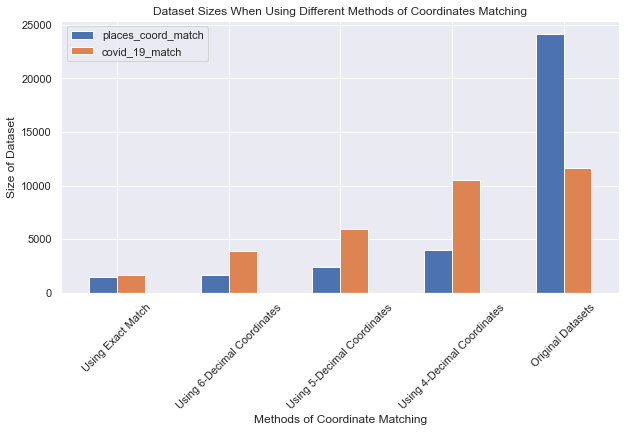

In [32]:
data_numbers.plot(x="case", kind="bar", by="rows", rot=45, figsize=(10,5))

plt.title("Dataset Sizes When Using Different Methods of Coordinates Matching")
plt.ylabel("Size of Dataset")
plt.xlabel("Methods of Coordinate Matching");

### Why we choose up to 4-decimal points method?

We should use up to 4-decimal point for making comparison for the perfect balance between *Accuracy* and *Flexibility*. Here is why: [GPS Precision](https://blis.com/precision-matters-critical-importance-decimal-places-five-lowest-go/)

Decimal Places | Decimal Degrees | Distance | Concept
:-------------:|:----------------|---------:|:-------
0 | 1.0 | 111 km | Can identify a Country or large Region from another
1 | 0.1 | 11.1 km | Can identify a large city from a neighbouring large city
2 | 0.01 | 1.11 km | Can identify a small village from the next
3 | 0.001 | 111 m | Can separate one neighbourhood or street from another
4 | 0.0001 | 11.1 m | Can identify an individual street or parcel of land.
5 | 0.00001 | 1.11 m | Capacity to distinguish one tree from another.
6 | 0.000001 | 11.1 cm | Measuring approximately 4 inches wide. Used for structural design & surveyance in engineering.
7 | 0.0000001 | 1.11 cm | Used for precision geographic surveying, representing the practical limit of the use of GPS.
8 | 0.00000001 | 1.11 mm | Conceptually the width of a paper clip. Can be used for charting volcanic movements & tectonic plate shifts.
9 | 0.000000001 | 111μm | Representative of the width of a strand of thread, now in the range of microscopy.